In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [29]:
fraud_df = pd.read_csv("../data/processed/fraud_feature_engineered.csv")
credit_df = pd.read_csv("../data/processed/creditcard_processed.csv")


In [30]:
drop_cols = ["user_id", "device_id"]  # High-cardinality IDs

X_fraud = fraud_df.drop(columns=["class"] + drop_cols)
y_fraud = fraud_df["class"]


In [31]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_fraud,
    y_fraud,
    test_size=0.2,
    stratify=y_fraud,
    random_state=42
)


In [32]:
categorical_cols = Xf_train.select_dtypes(include="object").columns

Xf_train = pd.get_dummies(Xf_train, columns=categorical_cols, drop_first=True)
Xf_test = pd.get_dummies(Xf_test, columns=categorical_cols, drop_first=True)

# Align test set to train columns
Xf_test = Xf_test.reindex(columns=Xf_train.columns, fill_value=0)


In [40]:
scaler = StandardScaler()
Xf_train_scaled = scaler.fit_transform(Xf_train)
Xf_test_scaled = scaler.transform(Xf_test)


In [41]:
log_reg_fraud = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg_fraud.fit(Xf_train_scaled, yf_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


AUC-PR: 0.6686523883601403
F1 Score: 0.6263528603332761


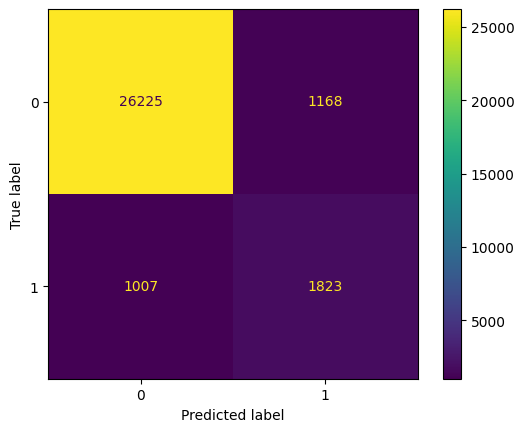

In [42]:
y_pred_lr = log_reg_fraud.predict(Xf_test_scaled)
y_proba_lr = log_reg_fraud.predict_proba(Xf_test_scaled)[:, 1]

print("AUC-PR:", average_precision_score(yf_test, y_proba_lr))
print("F1 Score:", f1_score(yf_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(yf_test, y_pred_lr)
plt.show()


In [43]:
rf_fraud = RandomForestClassifier(n_estimators=200, max_depth=10,
                                  class_weight="balanced", random_state=42, n_jobs=-1)
rf_fraud.fit(Xf_train, yf_train)  # Note: RF works on numeric + one-hot


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
rf_fraud = RandomForestClassifier(n_estimators=200, max_depth=10,
                                  class_weight="balanced", random_state=42, n_jobs=-1)
rf_fraud.fit(Xf_train, yf_train)  # Note: RF works on numeric + one-hot


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AUC-PR: 0.7170973802617814
F1 Score: 0.6137857252025065


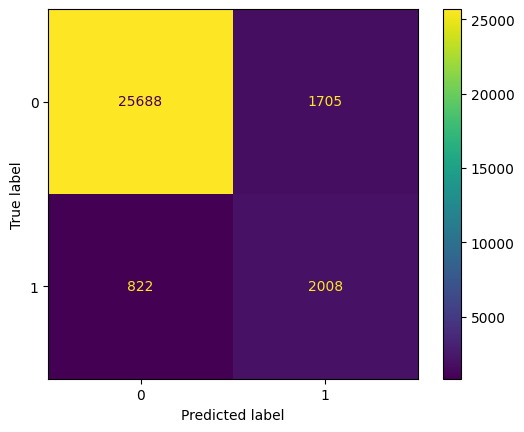

In [45]:
y_pred_rf = rf_fraud.predict(Xf_test)
y_proba_rf = rf_fraud.predict_proba(Xf_test)[:, 1]

print("AUC-PR:", average_precision_score(yf_test, y_proba_rf))
print("F1 Score:", f1_score(yf_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(yf_test, y_pred_rf)
plt.show()


In [46]:
# One-hot encode full X_fraud for CV
X_fraud_encoded = pd.get_dummies(X_fraud, columns=categorical_cols, drop_first=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"auc_pr": "average_precision", "f1": "f1"}

cv_results_fraud = cross_validate(rf_fraud, X_fraud_encoded, y_fraud, cv=cv, scoring=scoring)
pd.DataFrame(cv_results_fraud).agg(["mean", "std"])


,fit_time,score_time,test_auc_pr,test_f1
mean,35.184463,1.526796,0.719492,0.618596
std,2.818789,0.141805,0.012530,0.008512
